### Student Information
Name: 林孟璇

Student ID: 711233106

GitHub ID: 146575407

Kaggle name: sherrylin500

Kaggle private scoreboard snapshot:

![kaggle_scoreboard](./kaggle_scoreboard.jpg)

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__. 

In [1]:
### Begin Assignment Here

In [1]:
# import library
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import umap.umap_ as umap
import gensim
import tensorflow
import keras
import ollama
import langchain
import langchain_community
import langchain_core
import bs4
# import chromadb
import gradio

# %matplotlib inline

print("gensim: " + gensim.__version__)
print("tensorflow: " + tensorflow.__version__)
print("keras: " + keras.__version__)

c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


gensim: 4.3.3
tensorflow: 2.10.0
keras: 2.10.0


---
## 1. Data Preparation

### 1.1 Load data

print the json file and print the specified line with json.loads() and dumps()

In [ ]:
import json
import re
import sys

with open('tweets_DM.json', 'r') as f:
    for _ in range(5):
        print(json.dumps(json.loads(f.readline()), indent=4))

{
    "_score": 391,
    "_index": "hashtag_tweets",
    "_source": {
        "tweet": {
            "hashtags": [
                "Snapchat"
            ],
            "tweet_id": "0x376b20",
            "text": "People who post \"add me on #Snapchat\" must be dehydrated. Cuz man.... that's <LH>"
        }
    },
    "_crawldate": "2015-05-23 11:42:47",
    "_type": "tweets"
}
{
    "_score": 433,
    "_index": "hashtag_tweets",
    "_source": {
        "tweet": {
            "hashtags": [
                "freepress",
                "TrumpLegacy",
                "CNN"
            ],
            "tweet_id": "0x2d5350",
            "text": "@brianklaas As we see, Trump is dangerous to #freepress around the world. What a <LH> <LH> #TrumpLegacy.  #CNN"
        }
    },
    "_crawldate": "2016-01-28 04:52:09",
    "_type": "tweets"
}
{
    "_score": 232,
    "_index": "hashtag_tweets",
    "_source": {
        "tweet": {
            "hashtags": [
                "bibleverse"
            

count the number of lines in the file

In [5]:
with open('tweets_DM.json', 'r') as f:
    for i, _ in enumerate(f):
        pass
    print(i + 1)

1867535


convert json file to pands dataframe and rename the column names

In [19]:
data = []
with open('tweets_DM.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))
df = pd.json_normalize(data)

# replace the '_' in the start of the column names with ''
df.columns = df.columns.str.lstrip('_') 

# rename the coloumn names
df.rename(
    columns ={
        'source.tweet.hashtags': 'hashtags',
        'source.tweet.tweet_id': 'tweet_id', 
        'source.tweet.text': 'text'
        }, 
    inplace = True
)

df.shape

(1867535, 7)

merge column 'data_identification' to the dataframe

In [20]:
df_1 = pd.read_csv('data_identification.csv')
df = pd.merge(df, df_1, on = 'tweet_id')

print(df.shape)
df.head()

(1867535, 8)


,score,index,crawldate,type,hashtags,tweet_id,text,identification
0,391,hashtag_tweets,2015-05-23 11:42:47,tweets,[Snapchat],0x376b20,"People who post ""add me on #Snapchat"" must be ...",train
1,433,hashtag_tweets,2016-01-28 04:52:09,tweets,"[freepress, TrumpLegacy, CNN]",0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",train
2,232,hashtag_tweets,2017-12-25 04:39:20,tweets,[bibleverse],0x28b412,"Confident of your obedience, I write to you, k...",test
3,376,hashtag_tweets,2016-01-24 23:53:05,tweets,[],0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,train
4,989,hashtag_tweets,2016-01-08 17:18:59,tweets,[],0x2de201,"""Trust is not the same as faith. A friend is s...",test


separate the pands dataframe into df_train and df_test

In [21]:
df_train = df[df['identification'] == 'train']
df_test = df[df['identification'] == 'test']

merge column 'emotion' to the dataframe and take a look at the df_train

In [22]:
df_2 = pd.read_csv('emotion.csv')
df_train = pd.merge(df_train, df_2, on = 'tweet_id')

df_train.head()

,score,index,crawldate,type,hashtags,tweet_id,text,identification,emotion
0,391,hashtag_tweets,2015-05-23 11:42:47,tweets,[Snapchat],0x376b20,"People who post ""add me on #Snapchat"" must be ...",train,anticipation
1,433,hashtag_tweets,2016-01-28 04:52:09,tweets,"[freepress, TrumpLegacy, CNN]",0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",train,sadness
2,376,hashtag_tweets,2016-01-24 23:53:05,tweets,[],0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,train,fear
3,120,hashtag_tweets,2015-06-11 04:44:05,tweets,"[authentic, LaughOutLoud]",0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...,train,joy
4,1021,hashtag_tweets,2015-08-18 02:30:07,tweets,[],0x2c91a8,Still waiting on those supplies Liscus. <LH>,train,anticipation


take a look at the df_test

In [23]:
df_test.head()

,score,index,crawldate,type,hashtags,tweet_id,text,identification
2,232,hashtag_tweets,2017-12-25 04:39:20,tweets,[bibleverse],0x28b412,"Confident of your obedience, I write to you, k...",test
4,989,hashtag_tweets,2016-01-08 17:18:59,tweets,[],0x2de201,"""Trust is not the same as faith. A friend is s...",test
9,66,hashtag_tweets,2015-09-09 09:22:55,tweets,"[materialism, money, possessions]",0x218443,When do you have enough ? When are you satisfi...,test
30,104,hashtag_tweets,2015-10-10 14:33:26,tweets,"[GodsPlan, GodsWork]",0x2939d5,"God woke you up, now chase the day #GodsPlan #...",test
33,310,hashtag_tweets,2016-10-23 08:49:50,tweets,[],0x26289a,"In these tough times, who do YOU turn to as yo...",test


check the tweet of a specific tweet_id

In [24]:
df_test[df_test['tweet_id'] == '0x28cc61']

,score,index,crawldate,type,hashtags,tweet_id,text,identification
550171,107,hashtag_tweets,2017-01-17 14:13:32,tweets,[],0x28cc61,@Habbo I've seen two separate colours of the e...,test


take a look at the shape of df_train and df_test

In [25]:
print("Shape of Training df: ", df_train.shape)
print("Shape of Testing df: ", df_test.shape)

Shape of Training df:  (1455563, 9)
Shape of Testing df:  (411972, 8)


### 1.2 Data Visualization

Plot word frequency for Top 30 words in both train and test dataset.

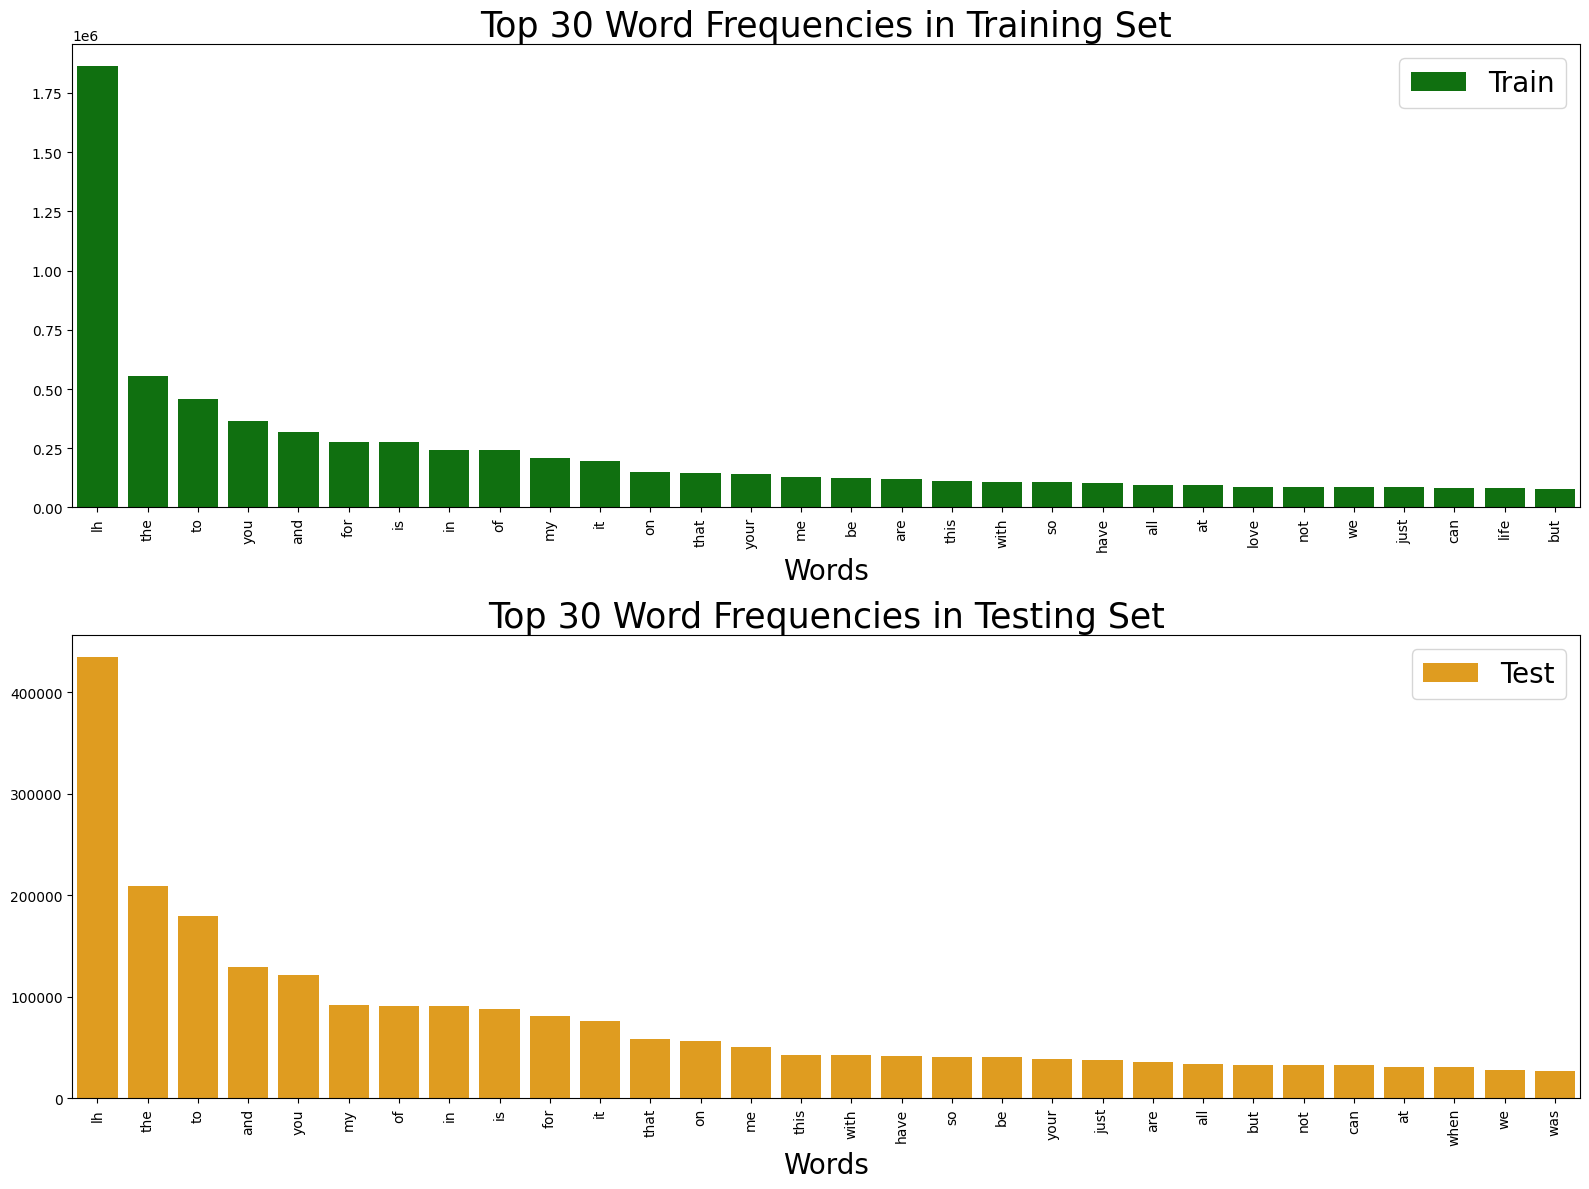

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
train_counts = count_vect.fit_transform(df_train['text'])
test_counts = count_vect.transform(df_test['text'])

train_term_frequencies = np.asarray(train_counts.sum(axis=0))[0]
test_term_frequencies = np.asarray(test_counts.sum(axis=0))[0]

train_word_freq = dict(zip(count_vect.get_feature_names_out(), train_term_frequencies))
test_word_freq = dict(zip(count_vect.get_feature_names_out(), test_term_frequencies))

train_top_30 = sorted(train_word_freq.items(), key=lambda x: x[1], reverse=True)[:30]
test_top_30 = sorted(test_word_freq.items(), key=lambda x: x[1], reverse=True)[:30]

train_top_words, train_top_freqs = zip(*train_top_30)
test_top_words, test_top_freqs = zip(*test_top_30)

plt.subplots(2, 1, figsize=(16, 12))

plt.subplot(2, 1, 1)
sns.barplot(x=train_top_words, y=train_top_freqs, label='Train', color='green')
plt.title('Top 30 Word Frequencies in Training Set', fontsize = 25)
plt.xticks(rotation=90)
plt.xlabel('Words', fontsize = 20)
plt.legend(fontsize = 20)

plt.subplot(2, 1, 2)
sns.barplot(x=test_top_words, y=test_top_freqs, label='Test', color='orange')
plt.title('Top 30 Word Frequencies in Testing Set', fontsize = 25)
plt.xticks(rotation=90)
plt.xlabel('Words', fontsize = 20)
plt.legend(fontsize = 20)

plt.tight_layout()
plt.show()

### 1.3 Save Data

save to pickle file

In [27]:
df_train.to_pickle('df_train.pkl')
df_test.to_pickle('df_test.pkl')

load the pickle file

In [28]:
df_train = pd.read_pickle('df_train.pkl')
df_test = pd.read_pickle('df_test.pkl')

### 1.4 Exploratory Data Analysis

Plot the distribution of the emotions in the training data

In [29]:
df_train.groupby(['emotion']).count()['text']

emotion
anger            39867
anticipation    248935
disgust         139101
fear             63999
joy             516017
sadness         193437
surprise         48729
trust           205478
Name: text, dtype: int64

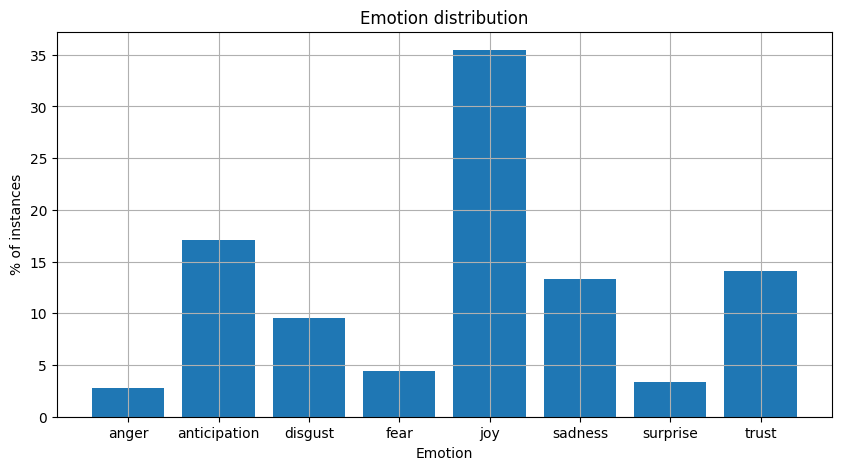

In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
labels = df_train['emotion'].unique()
post_total = len(df_train)
df_ = df_train.groupby(['emotion']).count()['text']
df_ = df_.apply(lambda x: round(x*100/post_total,3))

# plot
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(df_.index,df_.values)

# arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

## 2. Feature engineering

### 2.1 Text Pre-processing

In [34]:
import nltk

nltk.data.path = []
nltk.download('punkt', download_dir='C:/Users/USER/Desktop/作業和報告/研究所/資料探勘與應用/DM2024-Lab2-Homework/nltk_data')
nltk.download('punkt_tab', download_dir='C:/Users/USER/Desktop/作業和報告/研究所/資料探勘與應用/DM2024-Lab2-Homework/nltk_data')
nltk.download('stopwords', download_dir='C:/Users/USER/Desktop/作業和報告/研究所/資料探勘與應用/DM2024-Lab2-Homework/nltk_data')
nltk.download('wordnet', download_dir='C:/Users/USER/Desktop/作業和報告/研究所/資料探勘與應用/DM2024-Lab2-Homework/nltk_data')

nltk.data.path.append('C:/Users/USER/Desktop/作業和報告/研究所/資料探勘與應用/DM2024-Lab2-Homework/nltk_data')

[nltk_data] Downloading package punkt to C:/Users/USER/Desktop/作業和報告/研
[nltk_data]     究所/資料探勘與應用/DM2024-Lab2-Homework/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:/Users/USER/Desktop/作業和
[nltk_data]     報告/研究所/資料探勘與應用/DM2024-Lab2-Homework/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to C:/Users/USER/Desktop/作業和
[nltk_data]     報告/研究所/資料探勘與應用/DM2024-Lab2-Homework/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:/Users/USER/Desktop/作業和報告
[nltk_data]     /研究所/資料探勘與應用/DM2024-Lab2-Homework/nltk_data...


In [35]:
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import string
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

# Set the maximum number of words
vocab_size = 10000

# intialize the stop words
stop_words = set(stopwords.words('english'))
stop_words.remove('not')
stop_words.remove('but')

def process_text(text):
    if not isinstance(text, str):
        return ''
    # 1. lower case
    text = text.lower()
    # 2. delete URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # 3. replace # with HASHTAG_
    text = re.sub(r'#', ' HASHTAG_', text)
    # 4. remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    # 5. remove @
    text = re.sub(r'@\w+', '', text)
    # 6. remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # 7. remove numbers
    text = re.sub(r'\d+', '', text)
    # 8. remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # 9. lemmatize
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    # 10. remove extra spaces
    text = ' '.join(text.split())
    return text


df_train['text'] = df_train['text'].fillna('')
df_train['cleaned_text'] = df_train['text'].apply(process_text)

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['cleaned_text'])

print(tokenizer.texts_to_sequences([df_train['cleaned_text'][10]]))


[[19, 2384, 4046, 1, 777, 1, 4, 4046, 1, 1]]


In [40]:
display(df_train['text'].head())
display(df_train['cleaned_text'].head())

0    People who post "add me on #Snapchat" must be ...
1    @brianklaas As we see, Trump is dangerous to #...
2                  Now ISSA is stalking Tasha 😂😂😂 <LH>
3    @RISKshow @TheKevinAllison Thx for the BEST TI...
4         Still waiting on those supplies Liscus. <LH>
Name: text, dtype: object

0    people post add HASHTAGsnapchat must dehydrate...
1    see trump dangerous HASHTAGfreepress around wo...
2                              issa stalking tasha 😂😂😂
3    thx best time tonight story heartbreakingly HA...
4                          still waiting supply liscus
Name: cleaned_text, dtype: object

### 2.2 Prepare Data

get the sequences of the tweets using the tokenizer

In [41]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

padded_train_sequences = get_sequences(tokenizer, df_train['text'])

class labels

In [42]:
classes = set(labels)
print(classes)

{'disgust', 'anticipation', 'joy', 'surprise', 'fear', 'sadness', 'trust', 'anger'}


to ensure the order of the classes

In [44]:
classes = sorted(list(classes))
classes_to_index = {c: i for i, c in enumerate(classes)}
index_to_classes = {i: c for i, c in enumerate(classes)}

print('the classes to index: ', classes_to_index)
print('the index to classes: ', index_to_classes)

the classes to index:  {'anger': 0, 'anticipation': 1, 'disgust': 2, 'fear': 3, 'joy': 4, 'sadness': 5, 'surprise': 6, 'trust': 7}
the index to classes:  {0: 'anger', 1: 'anticipation', 2: 'disgust', 3: 'fear', 4: 'joy', 5: 'sadness', 6: 'surprise', 7: 'trust'}


In [47]:
# convert the labels to index
columns = lambda labels: np.array([classes_to_index.get(x) for x in labels])

# convert the index to labels
index = lambda index: np.array([index_to_classes.get(x) for x in index])

# to check the conversion
train_labels = columns(df_train['emotion'])
# test_labels = columns(df_test['emotion'])

print(train_labels[1:10])
# print(test_labels[1:10])

[5 3 4 1 4 5 1 4 0]


In [49]:
test_sequences = get_sequences(tokenizer, df_test['text'])
test_sequences

array([[2977,    1,    1, ...,    0,    0,    0],
       [ 255,    1,    2, ...,    0,    0,    0],
       [   1,    1,    1, ...,    0,    0,    0],
       ...,
       [   1,    1,  108, ...,    0,    0,    0],
       [   1, 1065,    1, ...,    0,    0,    0],
       [   1,    1,  722, ...,    0,    0,    0]])

## 3. Model LSTM

### 3.1 Construct model LSTM

builds a bidirectional LSTM model for the multi-class classification tasks

1. Embedding Layer: Converts words in the text into embedding vectors to capture semantic information.
2. First Bidirectional LSTM Layer: Processes the sequence bidirectionally to capture contextual information from both forward and backward directions.
3. Second Bidirectional LSTM Layer: Processes the output of the first LSTM layer and returns only the last hidden state.
4. Dropout Layer: Reduces overfitting by randomly setting 40% of the neurons to inactive during training.
5. Fully Connected Layer (Dense Layer): Applies a dense layer to further learn non-linear features.
6. Output Layer: Outputs the probabilities for 8 classes.

In [50]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, 128, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(8, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 50, 128)          98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

### 3.2 Train Model

Addresses class imbalance by assigning different weights to each class. Classes with fewer samples are given higher weights, while those with more samples are given lower weights.

In [51]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('logs/training_log.csv')

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_train['emotion']),
    y=df_train['emotion']
)
class_weights = dict(enumerate(class_weights))


history =  model.fit(padded_train_sequences,
                     train_labels,
                     callbacks=[csv_logger],
                     class_weight=class_weights,
                     epochs=3)



Epoch 1/3
45487/45487 [==============================] - 3986s 88ms/step - loss: 1.6231 - accuracy: 0.4009
Epoch 2/3
45487/45487 [==============================] - 4364s 96ms/step - loss: 1.5314 - accuracy: 0.4389
Epoch 3/3
45487/45487 [==============================] - 4778s 105ms/step - loss: 1.4996 - accuracy: 0.4486


### 3.3 Model Prediction

In [52]:
from sklearn.metrics import accuracy_score
preds = np.argmax(model.predict(test_sequences), axis=-1)

12875/12875 [==============================] - 512s 40ms/step


Take a look at the training accuracy and loss for each epoch

In [53]:
training_log = pd.DataFrame()
training_log = pd.read_csv('logs/training_log.csv')
training_log

,epoch,accuracy,loss
0,0,0.400877,1.623147
1,1,0.438854,1.531367
2,2,0.448641,1.499555


Plot the training accuracy and loss

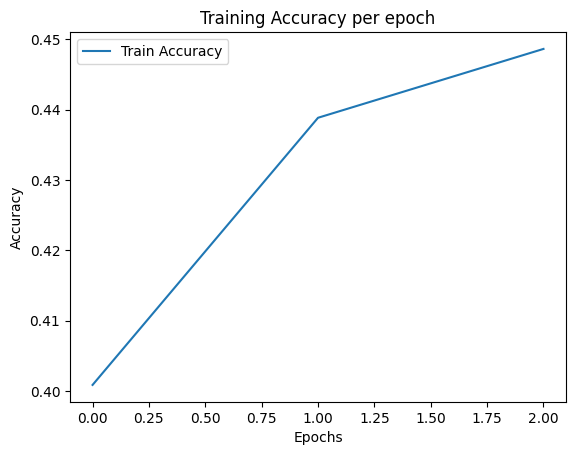

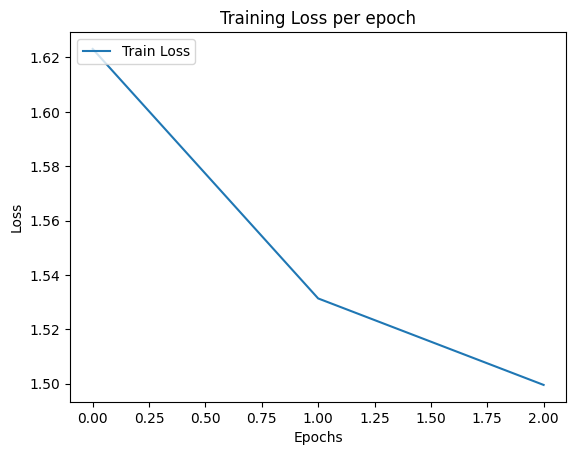

In [ ]:
training_log = pd.read_csv('logs/training_log.csv')

import matplotlib.pyplot as plt

plt.plot(training_log['accuracy'], label='Train Accuracy')
plt.title('Training Accuracy per epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc = 'upper left')
plt.show()

plt.plot(training_log['loss'], label='Train Loss')
plt.title('Training Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc = 'upper left')
plt.show()

Save the result to pandas dataframe and csv file

In [55]:
submission = pd.DataFrame({'id': df_test['tweet_id'], 'emotion': index(preds)})
submission.to_csv('submission.csv', index=False) 

In [56]:
submission

,id,emotion
2,0x28b412,trust
4,0x2de201,anticipation
9,0x218443,sadness
30,0x2939d5,trust
33,0x26289a,trust
...,...,...
1867525,0x2913b4,anticipation
1867529,0x2a980e,anticipation
1867530,0x316b80,anger
1867531,0x29d0cb,anger


Take a look at the distribution of the predictions

In [ ]:
submission.groupby(['emotion']).count()

,id
emotion,
anger,62228
anticipation,45064
disgust,85499
fear,26894
joy,60310
sadness,39054
surprise,28101
trust,64822


Here are the observations and conclusions:

1. Training Performance
- Accuracy: The training accuracy improved from 40.09% in the first epoch to 44.86% in the third epoch. This indicates that the model is learning, but the improvement rate is slow.
- Loss: The loss decreased from 1.623 to 1.500, showing that the model is optimizing during training. However, the final loss is still relatively high, which shows that the model is struggling to fit the data.

2. Testing Performance
- Accuracy: With a Kaggle submission accuracy of 39.945%, the model demonstrates limited generalization ability. This suggests a potential underfitting issue where the model does not fully capture the complexity of the dataset.

3. Improvement
- Enhance text preprocessing to retain useful features, for examples, we can try to use those words that is hashtaged for each sample.
- Experiment with larger vocab_size or adjust the LSTM unit size for better performance.